# **Clasificación de Imágenes de Pulmones con PySpark**

Autor: A01368818 Joel Sánchez Olvera

**Abstracto:**

Este script implementa una clasificación de imágenes de pulmones para identificar cuatro categorías de diagnóstico: neumonía, COVID-19, tuberculosis y normal. Utiliza PySpark para el procesamiento de datos, selección de modelo, ajuste de hiperparámetros y evaluación del modelo.

**Introducción**

El modelo presentado usa PySpark y MLlib para procesar y analizar grandes conjuntos de datos de imágenes, específicamente para clasificar imágenes de pulmones en diversas categorías de diagnóstico (como neumonía, COVID-19, tuberculosis y normal).

En éste notebook solucionamos el problema usando las tecnologías:
* PySpark, un marco de procesamiento de datos distribuido, nos permite manejar conjuntos de datos extensos al dividir las tareas en clústeres, lo que mejora la velocidad y eficiencia del procesamiento.
* MLlib, la biblioteca de aprendizaje automático de Spark, proporciona herramientas para algoritmos de aprendizaje automático escalables, optimizados para un rendimiento eficiente y adaptados al manejo de grandes volúmenes de datos.

**Descripción del Dataset**

El dataset utilizado está estructurado en tres carpetas principales: train, val y test, que representan los conjuntos de datos de entrenamiento, validación y prueba, respectivamente. Cada una de estas carpetas contiene cuatro subcarpetas, una para cada categoría de diagnóstico: NORMAL, PNEUMONIA, TUBERCULOSIS y COVID19. Las imágenes en cada subcarpeta corresponden a muestras de rayos X etiquetadas en su respectiva categoría.



Importamos las librerías necesarias para manejar pyspark y otros aspectos improtantes del código

In [1]:
#Bibliotecas para poder trabajar con Spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz
#Configuración de Spark con Python
!pip install -q findspark
!pip install pyspark

# #Estableciendo variable de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

#Buscando e inicializando la instalación de Spark
import findspark

findspark.init()
findspark.find()

from pyspark.sql import SparkSession, Row
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import os
from PIL import Image
import numpy as np



Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
49 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

In [3]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:

# Initialize Spark session if not already initialized
spark = SparkSession.builder \
    .appName("ImageClassification") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Define the root path for the dataset
dataset_path = "/content/drive/MyDrive/7mo Semestre ITC/Ismael/chest_Xray_dataset"

os.listdir(dataset_path)

# Create a list to hold the paths and labels
data = []

# # Iterate over the train, validation, and test directories
for dataset_type in ["train", "val", "test"]:
    dataset_type_path = os.path.join(dataset_path, dataset_type)
    for label in ["NORMAL", "PNEUMONIA", "TURBERCULOSIS", "COVID19"]:
        label_path = os.path.join(dataset_type_path, label)
        if os.path.isdir(label_path):  # Ensure the path exists and is a directory
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                data.append(Row(path=img_path, label=label, set_type=dataset_type))

# Convert the list to a PySpark DataFrame
df = spark.createDataFrame(data)
df.show(10)  # Display the first 100 entries to verify the paths and labels

# Count the number of images per class and dataset type
class_counts = df.groupBy('set_type', 'label').count().orderBy('label', 'set_type')
class_counts.show()  # Display the counts per class for each dataset type


+--------------------+------+--------+
|                path| label|set_type|
+--------------------+------+--------+
|/content/drive/My...|NORMAL|   train|
|/content/drive/My...|NORMAL|   train|
|/content/drive/My...|NORMAL|   train|
|/content/drive/My...|NORMAL|   train|
|/content/drive/My...|NORMAL|   train|
|/content/drive/My...|NORMAL|   train|
|/content/drive/My...|NORMAL|   train|
|/content/drive/My...|NORMAL|   train|
|/content/drive/My...|NORMAL|   train|
|/content/drive/My...|NORMAL|   train|
+--------------------+------+--------+
only showing top 10 rows

+--------+-------------+-----+
|set_type|        label|count|
+--------+-------------+-----+
|    test|      COVID19|  106|
|   train|      COVID19|  500|
|     val|      COVID19|   10|
|    test|       NORMAL|  234|
|   train|       NORMAL| 1361|
|     val|       NORMAL|    8|
|    test|    PNEUMONIA|  390|
|   train|    PNEUMONIA| 3895|
|     val|    PNEUMONIA|    8|
|    test|TURBERCULOSIS|   41|
|   train|TURBERCULOSIS| 

In [ ]:
# Máximo número de imágenes por clase
max_images_per_class = 1000

# Create a list to hold the paths and labels
data = []

# Create a dictionary to track the count of images per class
class_counts = {label: 0 for label in ["NORMAL", "PNEUMONIA", "TURBERCULOSIS", "COVID19"]}

# Iterate over the train, validation, and test directories
for dataset_type in ["train", "val", "test"]:
    dataset_type_path = os.path.join(dataset_path, dataset_type)
    for label in ["NORMAL", "PNEUMONIA", "TURBERCULOSIS", "COVID19"]:
        label_path = os.path.join(dataset_type_path, label)
        if os.path.isdir(label_path):  # Ensure the path exists and is a directory
            for img_file in os.listdir(label_path):
                # Check if the maximum images for the class have been reached
                if class_counts[label] >= max_images_per_class:
                    break

                img_path = os.path.join(label_path, img_file)
                data.append(Row(path=img_path, label=label, set_type=dataset_type))
                class_counts[label] += 1

# Convert the list to a PySpark DataFrame
df = spark.createDataFrame(data)

# Display the first few rows and class counts to verify the balance
df.show(10)
class_counts_df = spark.createDataFrame([Row(label=label, count=count) for label, count in class_counts.items()])
class_counts_df.show()

# Continue with the rest of the code
# Count the number of images per class and dataset type
class_counts = df.groupBy('set_type', 'label').count().orderBy('label', 'set_type')
class_counts.show()  # Display the counts per class for each dataset type


Ahora, comenzamos inicializando una sesión de Spark para crear un entorno capaz de manejar la gran escala de los datos de manera eficiente. El conjunto de datos, ubicado en Google Drive en la ruta establecida.

Nuestro dataset está organizado de la siguiente manera:

* Hay 3 directorios principales conteniendo los tipos de divisón en el dataset, los cuales son: train, val y test

* Dentro de cada una de esas divisiones tenemos 4 carpetas conteniendo imágenes de pulmones con las 4 clases a clasificar: NORMAL, PNEUMONIA, TUBERCULOSIS y COVID19


En el código anterior, para cada imagen, registramos su ruta de archivo, su etiqueta (el nombre de la enfermedad) y el tipo de conjunto de datos en una lista, que luego convertimos en un DataFrame de PySpark. Este formato de DataFrame es óptimo para el procesamiento distribuido de datos, lo que nos permite trabajar con los metadatos de las imágenes a gran escala con una buena eficiencia.

Con nuestros datos en un DataFrame pySpark, exploramos la distribución de imágenes por clases y tipos de conjunto, agrupándolas y contando la cantidad de imágenes en cada categoría. Con estos conteos, podemos verificar que la distribución de clases es balanceada entre los conjuntos train, val y test.

Este paso de verificación es fundamental, ya que un conjunto de datos equilibrado respalda un entrenamiento y evaluación del modelo más precisos, asegurando que cada clase esté representada equitativamente en el proceso de aprendizaje automático.

In [5]:
# Redimensiona las imágenes a 64x64 píxeles para reducir el tamaño
def procesar_imagen(ruta_imagen):
    img = Image.open(ruta_imagen).convert('L').resize((64, 64))
    return np.array(img).flatten().tolist()

# Procesa todas las imágenes y las almacena como filas en PySpark
datos_procesados = []
for fila in df.collect():
    caracteristicas = procesar_imagen(fila['path'])
    datos_procesados.append(Row(caracteristicas=caracteristicas, etiqueta=fila['label'], set_type=fila['set_type']))

# Creamos un nuevo DataFrame en PySpark con las características, etiquetas y tipo de conjunto
df_procesado = spark.createDataFrame(datos_procesados)

# Convertir la lista de características a un vector de características adecuado para MLlib
udf_to_dense_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
df_procesado = df_procesado.withColumn('features', udf_to_dense_vector('caracteristicas'))

# Asignar índices numéricos a las etiquetas
indexador = StringIndexer(inputCol="etiqueta", outputCol="label")
df_procesado = indexador.fit(df_procesado).transform(df_procesado)

# Seleccionar solo las columnas necesarias para el modelado
df_procesado = df_procesado.select('features', 'label', 'set_type')

df_procesado.show(20)




+--------------------+-----+--------+
|            features|label|set_type|
+--------------------+-----+--------+
|[34.0,56.0,102.0,...|  1.0|   train|
|[34.0,65.0,82.0,9...|  1.0|   train|
|[0.0,0.0,0.0,0.0,...|  1.0|   train|
|[0.0,0.0,10.0,34....|  1.0|   train|
|[95.0,106.0,112.0...|  1.0|   train|
|[73.0,86.0,96.0,1...|  1.0|   train|
|[63.0,89.0,113.0,...|  1.0|   train|
|[7.0,4.0,1.0,0.0,...|  1.0|   train|
|[80.0,83.0,84.0,8...|  1.0|   train|
|[39.0,69.0,89.0,1...|  1.0|   train|
|[21.0,43.0,54.0,5...|  1.0|   train|
|[0.0,0.0,0.0,1.0,...|  1.0|   train|
|[80.0,83.0,84.0,8...|  1.0|   train|
|[94.0,121.0,121.0...|  1.0|   train|
|[36.0,55.0,70.0,9...|  1.0|   train|
|[76.0,88.0,96.0,1...|  1.0|   train|
|[0.0,0.0,0.0,0.0,...|  1.0|   train|
|[41.0,53.0,60.0,6...|  1.0|   train|
|[80.0,83.0,84.0,8...|  1.0|   train|
|[110.0,159.0,144....|  1.0|   train|
|[154.0,151.0,152....|  1.0|   train|
|[46.0,66.0,80.0,8...|  1.0|   train|
|[70.0,74.0,116.0,...|  1.0|   train|
|[0.0,0.0,9.

Después, en el bloque de código anterior, realizamos el procesamiento de las imágenes del conjunto de datos, redimensionándolas a 64x64 píxeles y convirtiéndolas a escala de grises. Este paso es crucial para reducir la dimensionalidad de las imágenes, lo que facilita y acelera el procesamiento sin perder demasiada información visual importante en el acto.

La redimension también ayuda a estandarizar el tamaño de las imágenes, asegurando que todas tengan las mismas dimensiones y colores para el análisis y el modelo de aprendizaje automático.

La función procesar_imagen abre cada imagen, la convierte a escala de grises y la redimensiona. Luego, convierte la imagen en una lista unidimensional de píxeles (flattened array), que representa las características de la imagen en un formato vectorial. Estas características, junto con la etiqueta de cada imagen, se almacenan en una lista de filas.

Finalmente, la lista es convertida a un nuevo DataFrame de PySpark llamado df_procesado, que contiene la información de características y etiquetas, y se visualizan las primeras 100 entradas para verificar que el procesamiento fue correcto.

In [6]:
# Dividir los datos en conjuntos de entrenamiento y prueba utilizando 'set_type'
df_entrenamiento = df_procesado.filter(df_procesado.set_type == 'train')
df_prueba = df_procesado.filter(df_procesado.set_type == 'test')

# Si existe un conjunto de validación, también puedes obtenerlo
df_validacion = df_procesado.filter(df_procesado.set_type == 'val')

# Definir y entrenar el modelo de Regresión Logística
regresion_logistica = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
modelo = regresion_logistica.fit(df_entrenamiento)

# Generar predicciones en el conjunto de prueba
predicciones = modelo.transform(df_prueba)

In [7]:
predicciones.show(20)

+--------------------+-----+--------+--------------------+--------------------+----------+
|            features|label|set_type|       rawPrediction|         probability|prediction|
+--------------------+-----+--------+--------------------+--------------------+----------+
|[8.0,10.0,10.0,10...|  1.0|    test|[-3.5368472753515...|[0.00254336058172...|       2.0|
|[31.0,31.0,29.0,2...|  1.0|    test|[-2.0145101835606...|[0.01373429506622...|       2.0|
|[22.0,20.0,20.0,1...|  1.0|    test|[-0.9997049691536...|[0.05809037857102...|       2.0|
|[9.0,10.0,10.0,10...|  1.0|    test|[-3.5675055475278...|[0.00215778828104...|       1.0|
|[12.0,12.0,11.0,1...|  1.0|    test|[-1.2880789652695...|[0.05509238672652...|       1.0|
|[0.0,0.0,62.0,116...|  1.0|    test|[-3.9833172864746...|[0.00147955327325...|       1.0|
|[18.0,20.0,18.0,1...|  1.0|    test|[-2.7287344826037...|[0.00614010089978...|       1.0|
|[16.0,16.0,17.0,1...|  1.0|    test|[-2.8242385538622...|[0.00367346307361...|       2.0|

En el código anterior, implementamos un  modelo de regresión logística utilizando PySpark MLlib, orientado a clasificar imágenes preprocesadas en diferentes categorías. Este modelo es una herramienta de aprendizaje supervisado que nos permite predecir la clase de una imagen basada en características específicas que describen cada imagen.

Primero convertimos las características de cada imagen en un formato vectorial compatible con Spark mediante VectorAssembler. Esta transformación es fundamental porque Spark MLlib requiere que las características se encuentren en un vector estructurado (features_vector) para procesarlos. Luego, las etiquetas de las imágenes, que representan las categorías o clases de cada imagen (como NORMAL o PNEUMONIA), se indexan numéricamente usando StringIndexer.

 El conjunto de entrenamiento se utiliza para ajustar el modelo y permitirle aprender a identificar patrones en las características que corresponden a cada clase. El conjunto de prueba se reserva para evaluar la capacidad del modelo de hacer predicciones precisas sobre datos no vistos, lo cual nos proporciona una medición objetiva de su rendimiento.

Finalmente, el modelo de regresión logística se entrena usando el conjunto de entrenamiento.

In [8]:
# Evaluar la precisión del modelo en el conjunto de prueba
evaluador = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
exactitud = evaluador.evaluate(predicciones)
print(f"Precisión en el conjunto de prueba: {exactitud * 100:.2f}%")

# Métricas adicionales de evaluación: cálculo del puntaje F1
evaluador_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
puntaje_f1 = evaluador_f1.evaluate(predicciones)
print(f"Puntaje F1: {puntaje_f1:.2f}")

# Muestra una selección de 10 predicciones
predicciones.select("features", "label", "prediction").show(20)

Precisión en el conjunto de prueba: 77.95%
Puntaje F1: 0.77
+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[8.0,10.0,10.0,10...|  1.0|       2.0|
|[31.0,31.0,29.0,2...|  1.0|       2.0|
|[22.0,20.0,20.0,1...|  1.0|       2.0|
|[9.0,10.0,10.0,10...|  1.0|       1.0|
|[12.0,12.0,11.0,1...|  1.0|       1.0|
|[0.0,0.0,62.0,116...|  1.0|       1.0|
|[18.0,20.0,18.0,1...|  1.0|       1.0|
|[16.0,16.0,17.0,1...|  1.0|       2.0|
|[25.0,25.0,23.0,2...|  1.0|       2.0|
|[125.0,133.0,137....|  1.0|       1.0|
|[19.0,19.0,18.0,1...|  1.0|       2.0|
|[21.0,21.0,20.0,1...|  1.0|       2.0|
|[26.0,27.0,25.0,2...|  1.0|       2.0|
|[16.0,18.0,18.0,1...|  1.0|       2.0|
|[36.0,35.0,34.0,3...|  1.0|       2.0|
|[6.0,6.0,6.0,5.0,...|  1.0|       3.0|
|[4.0,4.0,4.0,4.0,...|  1.0|       2.0|
|[75.0,82.0,96.0,8...|  1.0|       2.0|
|[28.0,43.0,92.0,1...|  1.0|       1.0|
|[2.0,4.0,5.0,5.0,...|  1.0|       1.0|
|[39.0,37.0,35.0,3..

Después enéste código evaluamos el rendimiento del modelo de regresión logística que hemos entrenado, usando métricas de accuracy y puntaje F1 sobre el conjunto de prueba.

Primero, generamos predicciones aplicando el modelo sobre df_prueba, lo que permite obtener una columna prediction en la que se almacenan las etiquetas predichas para cada instancia. Luego, calculamos la precisión del modelo, que indica el porcentaje de predicciones correctas en el conjunto de prueba y calculamos el puntaje F1 (F1 Score), una métrica que combina precisión y exhaustividad, especialmente útil en escenarios con clases desbalanceadas. Esto nos proporciona una evaluación más completa del rendimiento del modelo. Finalmente, mostramos una muestra de 100 predicciones generadas.

Podemos concluir de nuestros resultados que tenemos un sustema de predicciones funcional y eficiente, y tenemos un manejo bueno de pySpark para facilitar el manejo del gran volumen de datos en el dataset.








Finalmente exportamos los datos para poder visualizarlos en Tableau

In [11]:
from pyspark.sql.functions import col, expr

class_counts.toPandas().to_csv("/content/class_counts.csv", index=False)


predicciones = predicciones.withColumn("isCorrect", expr("label = prediction"))
predicciones.select("features", "label", "prediction","probability", "isCorrect").toPandas().to_csv("/content/predictions.csv", index=False)


results = predicciones.select("label", "prediction").toPandas()
results.to_csv("/content/predictions_results.csv", index=False)

In [ ]:
#FULL CODE
#Bibliotecas para poder trabajar con Spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz
#Configuración de Spark con Python
!pip install -q findspark
!pip install pyspark

# #Estableciendo variable de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

#Buscando e inicializando la instalación de Spark
import findspark

findspark.init()
findspark.find()

from pyspark.sql import SparkSession, Row
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import os
from PIL import Image
import numpy as np


from google.colab import drive
drive.mount('/content/drive')


# Initialize Spark session if not already initialized
spark = SparkSession.builder \
    .appName("ImageClassification") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Define the root path for the dataset
dataset_path = "/content/drive/MyDrive/7mo Semestre ITC/Ismael/chest_Xray_dataset"

os.listdir(dataset_path)

# Create a list to hold the paths and labels
data = []

# # Iterate over the train, validation, and test directories
for dataset_type in ["train", "val", "test"]:
    dataset_type_path = os.path.join(dataset_path, dataset_type)
    for label in ["NORMAL", "PNEUMONIA", "TURBERCULOSIS", "COVID19"]:
        label_path = os.path.join(dataset_type_path, label)
        if os.path.isdir(label_path):  # Ensure the path exists and is a directory
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                data.append(Row(path=img_path, label=label, set_type=dataset_type))

# Convert the list to a PySpark DataFrame
df = spark.createDataFrame(data)
df.show(10)  # Display the first 100 entries to verify the paths and labels

# Count the number of images per class and dataset type
class_counts = df.groupBy('set_type', 'label').count().orderBy('label', 'set_type')
class_counts.show()  # Display the counts per class for each dataset type

# Redimensiona las imágenes a 64x64 píxeles para reducir el tamaño
def procesar_imagen(ruta_imagen):
    img = Image.open(ruta_imagen).convert('L').resize((64, 64))
    return np.array(img).flatten().tolist()

# Procesa todas las imágenes y las almacena como filas en PySpark
datos_procesados = []
for fila in df.collect():
    caracteristicas = procesar_imagen(fila['path'])
    datos_procesados.append(Row(caracteristicas=caracteristicas, etiqueta=fila['label'], set_type=fila['set_type']))

# Creamos un nuevo DataFrame en PySpark con las características, etiquetas y tipo de conjunto
df_procesado = spark.createDataFrame(datos_procesados)

# Convertir la lista de características a un vector de características adecuado para MLlib
udf_to_dense_vector = udf(lambda x: Vectors.dense(x), VectorUDT())
df_procesado = df_procesado.withColumn('features', udf_to_dense_vector('caracteristicas'))

# Asignar índices numéricos a las etiquetas
indexador = StringIndexer(inputCol="etiqueta", outputCol="label")
df_procesado = indexador.fit(df_procesado).transform(df_procesado)

# Seleccionar solo las columnas necesarias para el modelado
df_procesado = df_procesado.select('features', 'label', 'set_type')

df_procesado.show(10)


# Dividir los datos en conjuntos de entrenamiento y prueba utilizando 'set_type'
df_entrenamiento = df_procesado.filter(df_procesado.set_type == 'train')
df_prueba = df_procesado.filter(df_procesado.set_type == 'test')

# Si existe un conjunto de validación, también puedes obtenerlo
df_validacion = df_procesado.filter(df_procesado.set_type == 'val')

# Definir y entrenar el modelo de Regresión Logística
regresion_logistica = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
modelo = regresion_logistica.fit(df_entrenamiento)

# Generar predicciones en el conjunto de prueba
predicciones = modelo.transform(df_prueba)

# Evaluar la precisión del modelo en el conjunto de prueba
evaluador = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
exactitud = evaluador.evaluate(predicciones)
print(f"Precisión en el conjunto de prueba: {exactitud * 100:.2f}%")

# Métricas adicionales de evaluación: cálculo del puntaje F1
evaluador_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
puntaje_f1 = evaluador_f1.evaluate(predicciones)
print(f"Puntaje F1: {puntaje_f1:.2f}")

# Muestra una selección de 10 predicciones
predicciones.select("features", "label", "prediction").show(100)


#**TABLEAU**

## **Primera Gráfica (Distribución de Clases en el Dataset)**

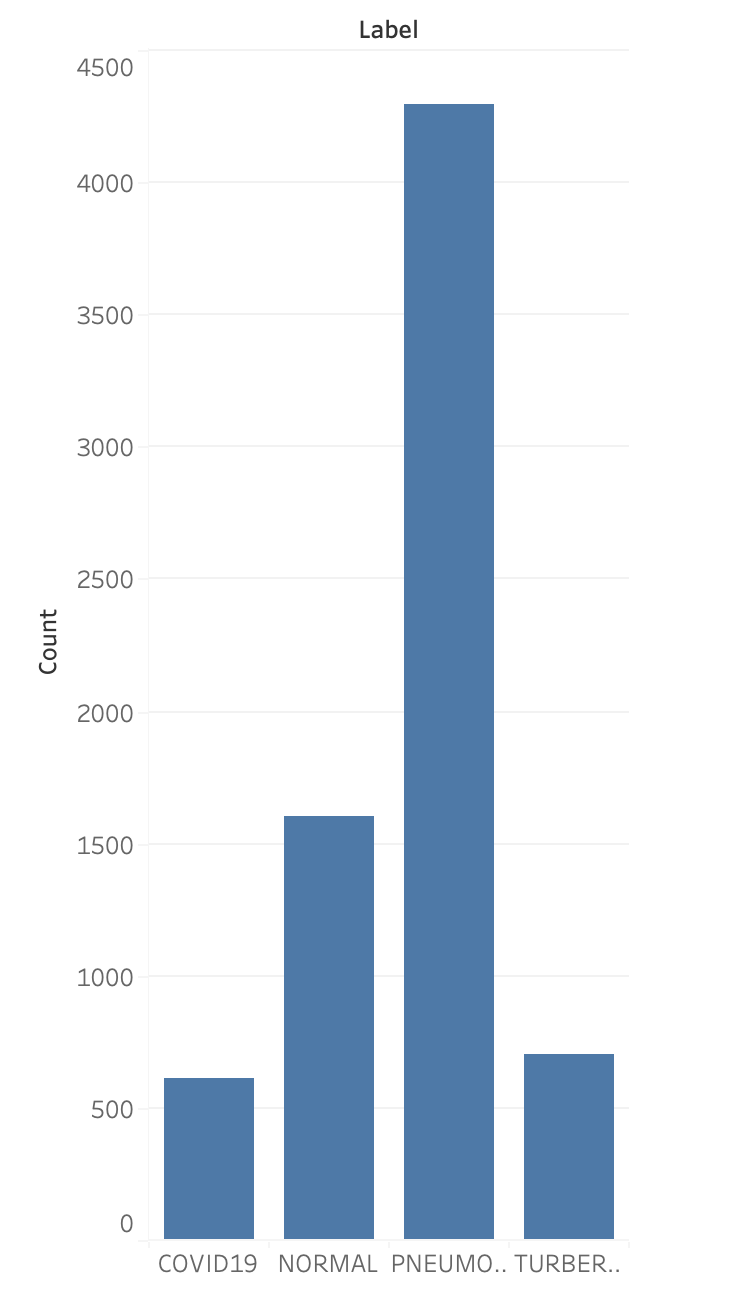

**Descripción:**

Esta gráfica de barras muestra el número de imágenes disponibles en el dataset para cada clase (Label). Las clases representadas son: COVID19, NORMAL, PNEUMONIA, y TUBERCULOSIS. La altura de las barras representa la cantidad de imágenes por clase.

**Análisis**:

La clase Pneumonía domina el dataset con la mayor cantidad de imágenes con poco menos de 4500 imágenes.
Las clases PNEUMONIA (~2000 imágenes) y TUBERCULOSIS (~500 imágenes) tienen menos representación.
La clase COVID19 tiene la menor cantidad de datos (~500 imágenes), lo que podría afectar la capacidad del modelo para aprender correctamente patrones relacionados con esta clase.
Esta distribución no es balanceada, lo que podría introducir sesgos en el entrenamiento del modelo, favoreciendo la clase mayoritaria (NORMAL) y afectando negativamente el rendimiento en las clases minoritarias.

## **Segunda Gráfica (Predicciones Correctas vs Incorrectas por Clase)**

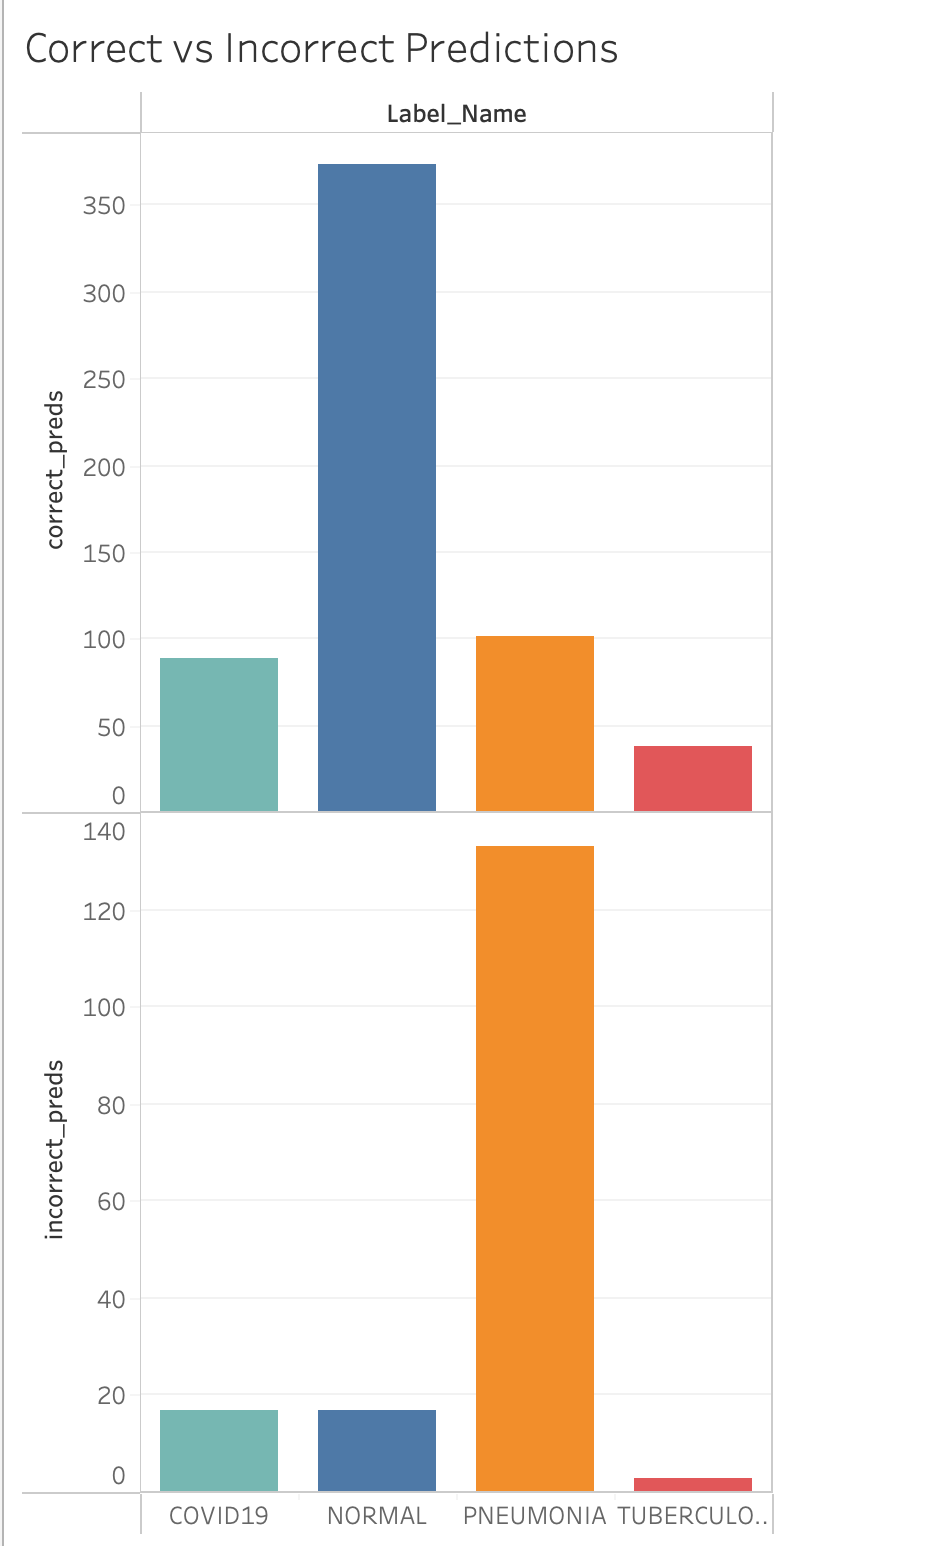

**Descripción:**

Esta gráfica de barras está dividida en dos secciones:
* **Correct Predictions (Predicciones Correctas):** Número de imágenes clasificadas correctamente para cada clase.
* **Incorrect Predictions (Predicciones Incorrectas):** Número de imágenes clasificadas incorrectamente para cada clase.
Las clases se agrupan en el eje X, y el conteo de predicciones se representa en el eje Y.

**Análisis:**

* **Correct Predictions:** La clase NORMAL tiene la mayor cantidad de predicciones correctas (~350), lo que es consistente con la mayor cantidad de datos en esta clase.
PNEUMONIA tiene un número moderado de predicciones correctas (100).
Las clases COVID19 y TUBERCULOSIS tienen muy pocas predicciones correctas (50), lo que podría deberse a su menor representación en el dataset.

* **Incorrect Predictions:** La clase PNEUMONIA tiene el mayor número de predicciones incorrectas (140). Esto podría deberse a confusiones frecuentes con otras clases. Las clases COVID19 y TUBERCULOSIS tienen muy pocos errores (20-30), pero esto podría ser porque también tienen menos imágenes en total.
La clase NORMAL tiene relativamente pocos errores (50), lo que indica que el modelo se desempeña bien en esta clase.

**Conclusiones:**

* El modelo tiene un mejor desempeño en la clase NORMAL, pero lucha con las clases minoritarias, especialmente PNEUMONIA.
* La alta cantidad de errores para PNEUMONIA podría indicar que esta clase comparte características visuales con otras clases, causando confusiones.
* La falta de datos balanceados está afectando el desempeño global del modelo, especialmente para las clases COVID19 y TUBERCULOSIS.